In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


100%|██████████| 24088/24088 [00:00<00:00, 228317.15it/s]


Skipping 61_1_20170109150557335.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Skipping 61_1_20170109142408075.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping 39_1_20170116174525125.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'


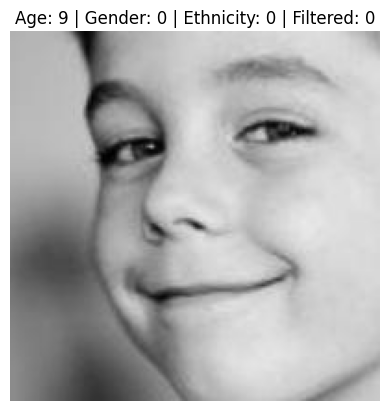

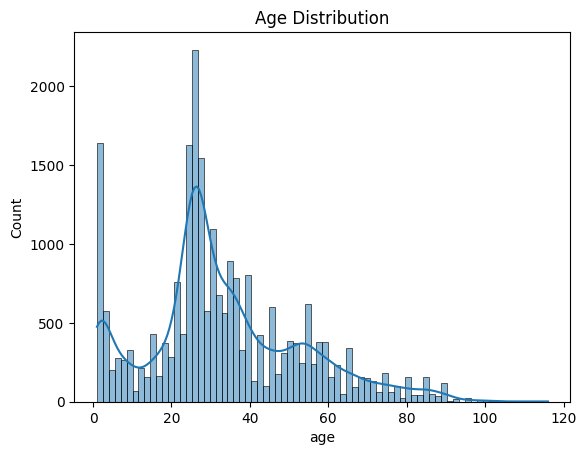

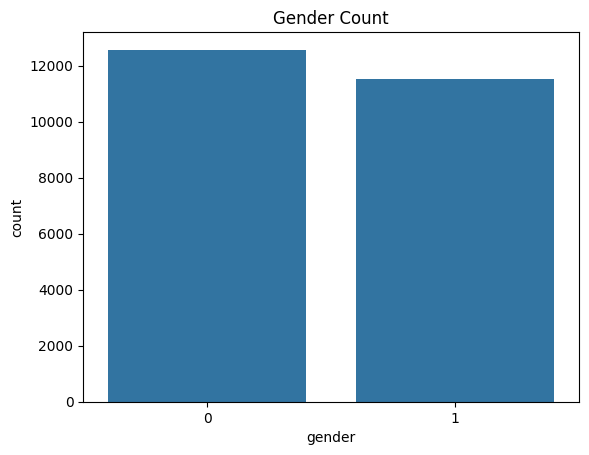

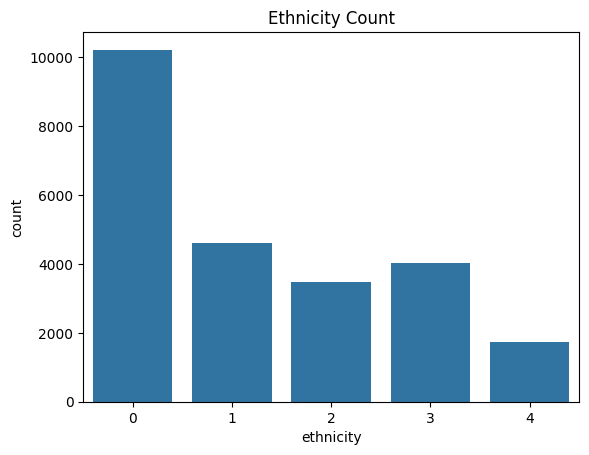

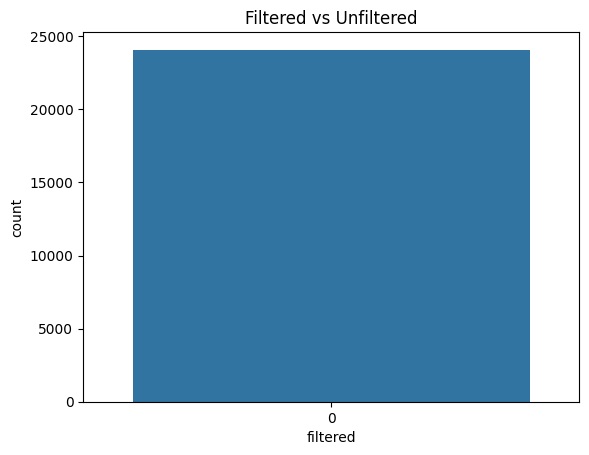

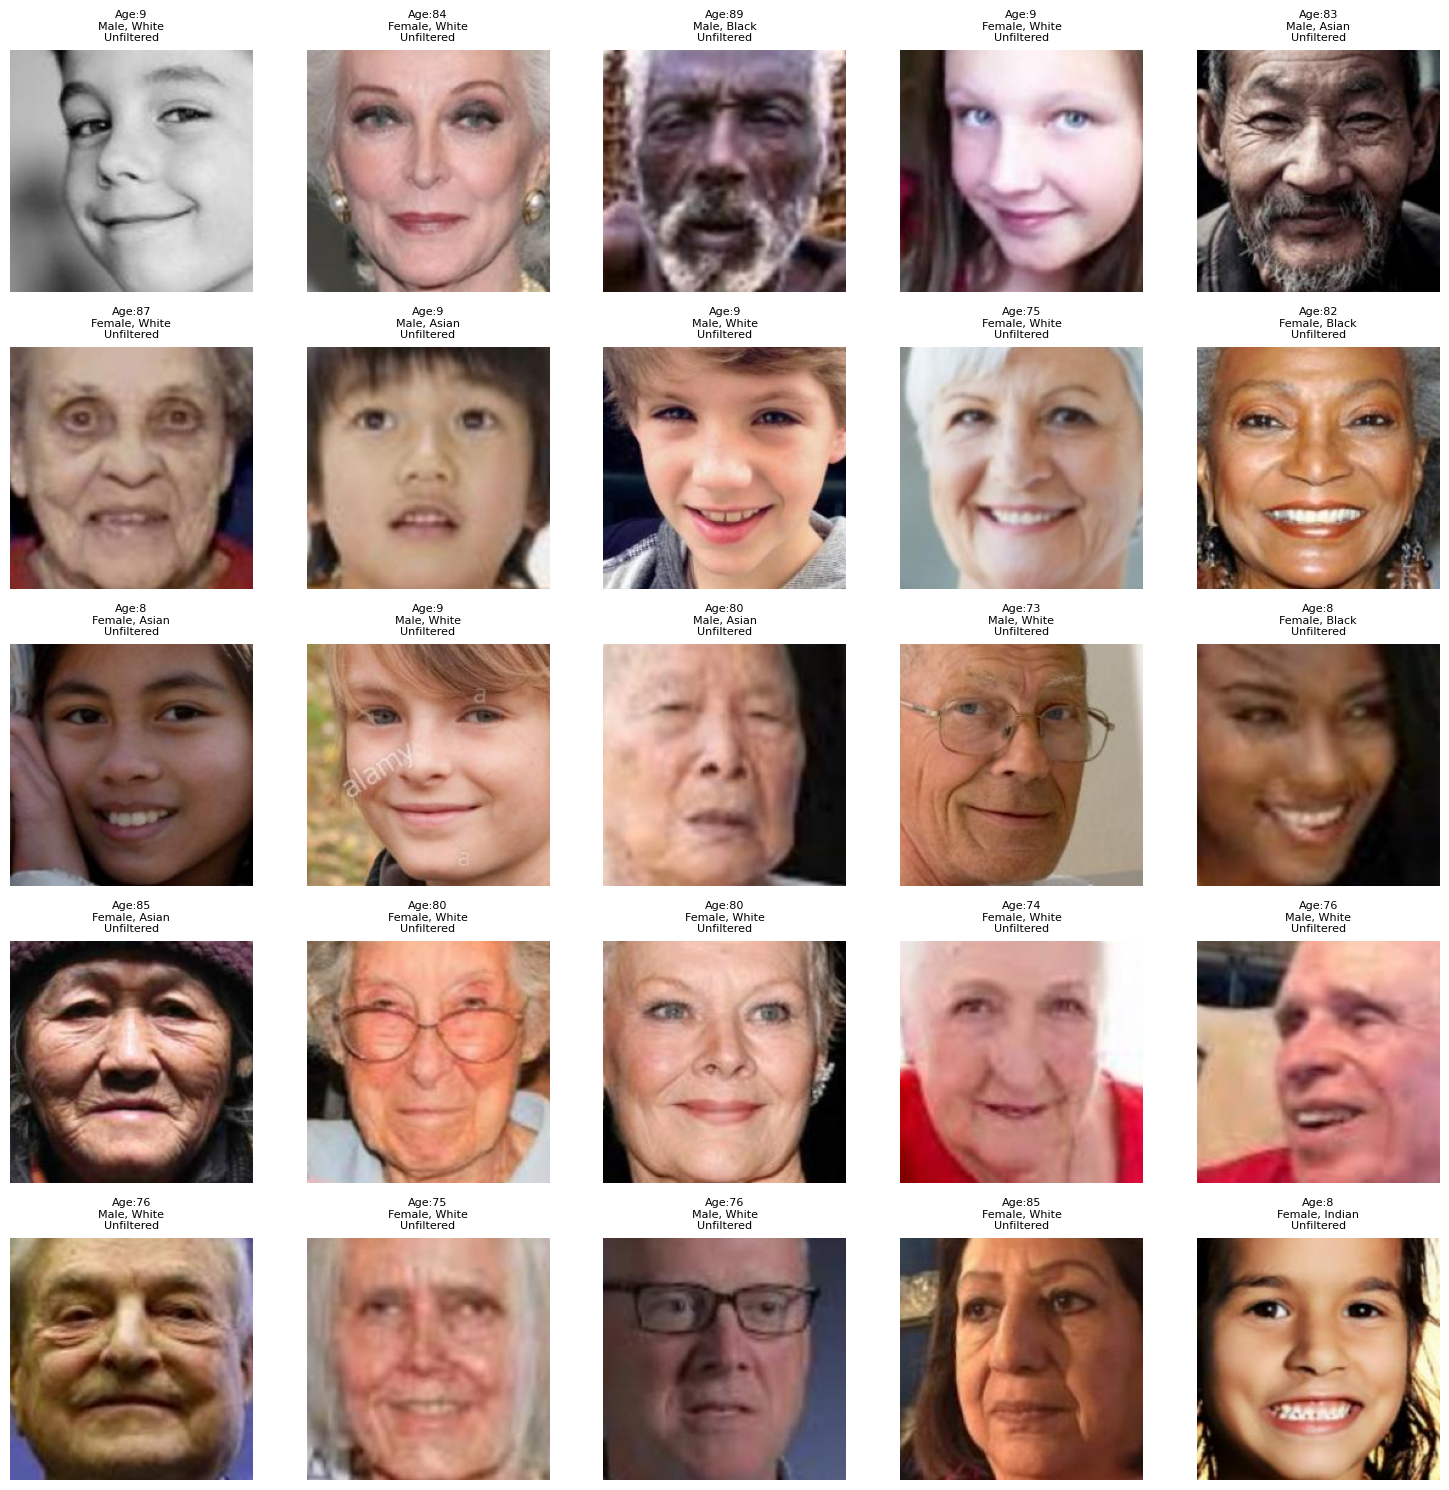

  1%|          | 244/24085 [00:29<47:49,  8.31it/s] 


KeyboardInterrupt: 

In [ ]:
# Importing Modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.utils import to_categorical

# ✅ Path to UTKFace dataset
BASE_DIR = "/content/drive/MyDrive/UTKFace"

# Load the Dataset
image_paths, age_labels, gender_labels, ethnicity_labels, filter_labels = [], [], [], [], []

def is_filtered(filename):
    # You can customize this rule based on how filtered images are named
    return 1 if 'filtered' in filename.lower() else 0

for filename in tqdm(os.listdir(BASE_DIR)):
    if filename.endswith(".jpg"):
        try:
            parts = filename.split('_')
            age = int(parts[0])
            gender = int(parts[1])
            ethnicity = int(parts[2])
            image_path = os.path.join(BASE_DIR, filename)
            is_filter = is_filtered(filename)

            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
            ethnicity_labels.append(ethnicity)
            filter_labels.append(is_filter)
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

# DataFrame creation
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels,
    'ethnicity': ethnicity_labels,
    'filtered': filter_labels
})

# ✅ Check Data
if df.empty:
    print("❌ No data found. Check UTKFace folder path or file names.")
    exit()

# ✅ Show one image
img = Image.open(df.iloc[0]['image'])
plt.axis('off')
plt.imshow(img)
plt.title(f"Age: {df.iloc[0]['age']} | Gender: {df.iloc[0]['gender']} | Ethnicity: {df.iloc[0]['ethnicity']} | Filtered: {df.iloc[0]['filtered']}")
plt.show()

# EDA
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

sns.countplot(x='gender', data=df)
plt.title("Gender Count")
plt.show()

sns.countplot(x='ethnicity', data=df)
plt.title("Ethnicity Count")
plt.show()

sns.countplot(x='filtered', data=df)
plt.title("Filtered vs Unfiltered")
plt.show()

# Dictionaries
gender_dict = {0: "Male", 1: "Female"}
ethnicity_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}

# ✅ Display 25 sample images
plt.figure(figsize=(15, 15))
for index in range(25):
    row = df.iloc[index]
    img = load_img(row['image'])
    plt.subplot(5, 5, index + 1)
    plt.imshow(img)
    gender = gender_dict.get(row['gender'], 'Unknown')
    ethnicity = ethnicity_dict.get(row['ethnicity'], 'Unknown')
    filtered = "Filtered" if row['filtered'] else "Unfiltered"
    plt.title(f"Age:{row['age']}\n{gender}, {ethnicity}\n{filtered}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

# ✅ Feature Extraction (Fixed Image.ANTIALIAS issue)
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

# Preprocessing
X = extract_features(df['image']) / 255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_ethnicity = to_categorical(np.array(df['ethnicity']), num_classes=5)
y_filtered = np.array(df['filtered'])

# Model Architecture
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Gender Head
g = Dense(256, activation='relu')(x)
g = Dropout(0.3)(g)
gender_out = Dense(1, activation='sigmoid', name='gender_out')(g)

# Age Head
a = Dense(256, activation='relu')(x)
a = Dropout(0.3)(a)
age_out = Dense(1, activation='relu', name='age_out')(a)

# Ethnicity Head
e = Dense(256, activation='relu')(x)
e = Dropout(0.3)(e)
ethnicity_out = Dense(5, activation='softmax', name='ethnicity_out')(e)

# Filtered Head
f = Dense(256, activation='relu')(x)
f = Dropout(0.3)(f)
filter_out = Dense(1, activation='sigmoid', name='filter_out')(f)

# Model Definition
model = Model(inputs=inputs, outputs=[gender_out, age_out, ethnicity_out, filter_out])

model.compile(
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'mae',
        'ethnicity_out': 'categorical_crossentropy',
        'filter_out': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics={
        'gender_out': 'accuracy',
        'age_out': 'mae',
        'ethnicity_out': 'accuracy',
        'filter_out': 'accuracy'
    }
)

# Training
history = model.fit(
    X,
    {
        'gender_out': y_gender,
        'age_out': y_age,
        'ethnicity_out': y_ethnicity,
        'filter_out': y_filtered
    },
    batch_size=32,
    epochs=10,
    validation_split=0.2
)

# # Plot Gender Accuracy
# plt.plot(history.history['gender_out_accuracy'], label='Train Gender Acc')
# plt.plot(history.history['val_gender_out_accuracy'], label='Val Gender Acc')
# plt.title("Gender Classification Accuracy")
# plt.legend()
# plt.show()

# # Plot Age MAE
# plt.plot(history.history['age_out_mae'], label='Train Age MAE')
# plt.plot(history.history['val_age_out_mae'], label='Val Age MAE')
# plt.title("Age Prediction MAE")
# plt.legend()
# plt.show()

# # Plot Ethnicity Accuracy
# plt.plot(history.history['ethnicity_out_accuracy'], label='Train Ethnicity Acc')
# plt.plot(history.history['val_ethnicity_out_accuracy'], label='Val Ethnicity Acc')
# plt.title("Ethnicity Classification Accuracy")
# plt.legend()
# plt.show()

# # Plot Filter Prediction Accuracy
# plt.plot(history.history['filter_out_accuracy'], label='Train Filter Acc')
# plt.plot(history.history['val_filter_out_accuracy'], label='Val Filter Acc')
# plt.title("Filter Detection Accuracy")
# plt.legend()
# plt.show()


100%|██████████| 24088/24088 [00:00<00:00, 218889.04it/s]


Skipping 61_1_20170109150557335.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Skipping 61_1_20170109142408075.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping 39_1_20170116174525125.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'


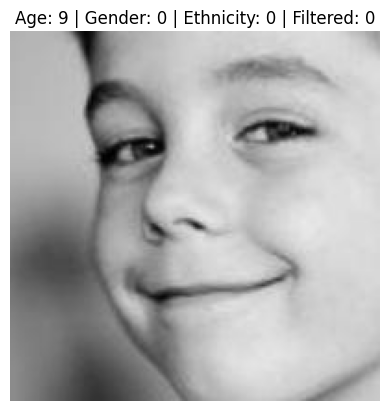

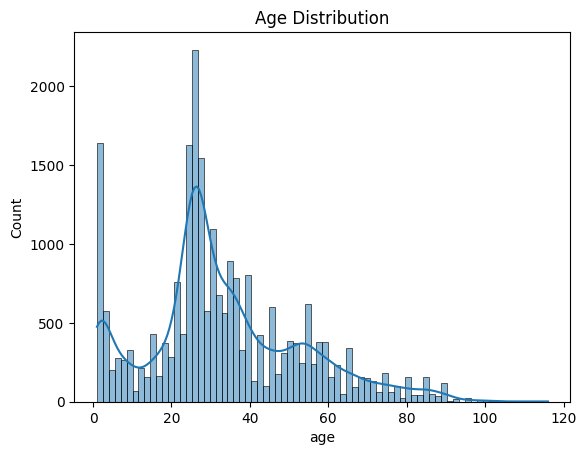

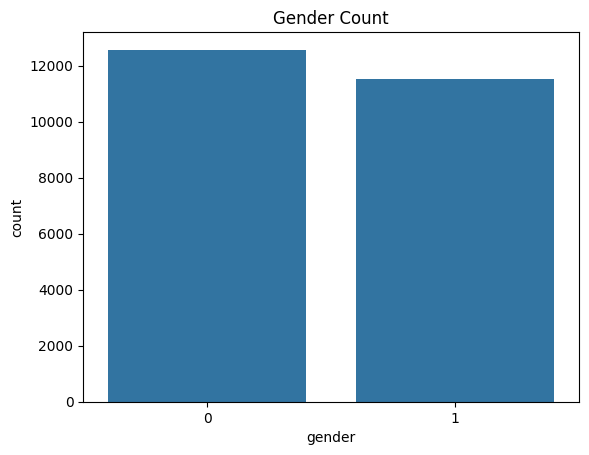

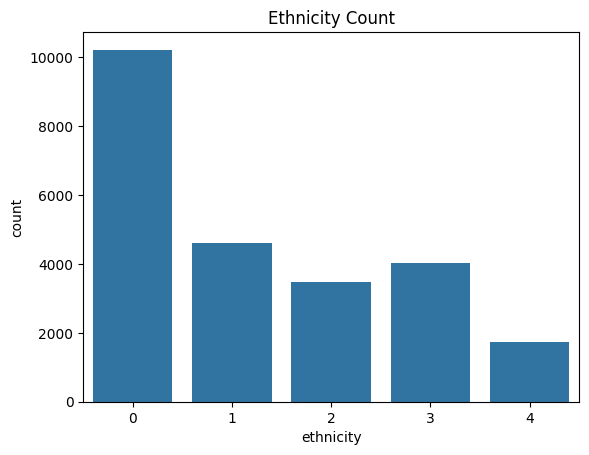

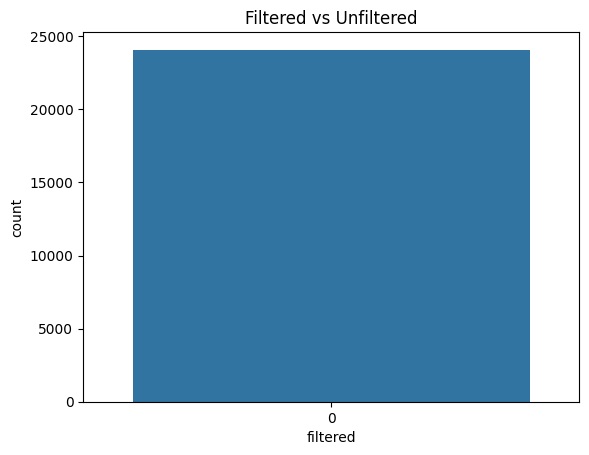

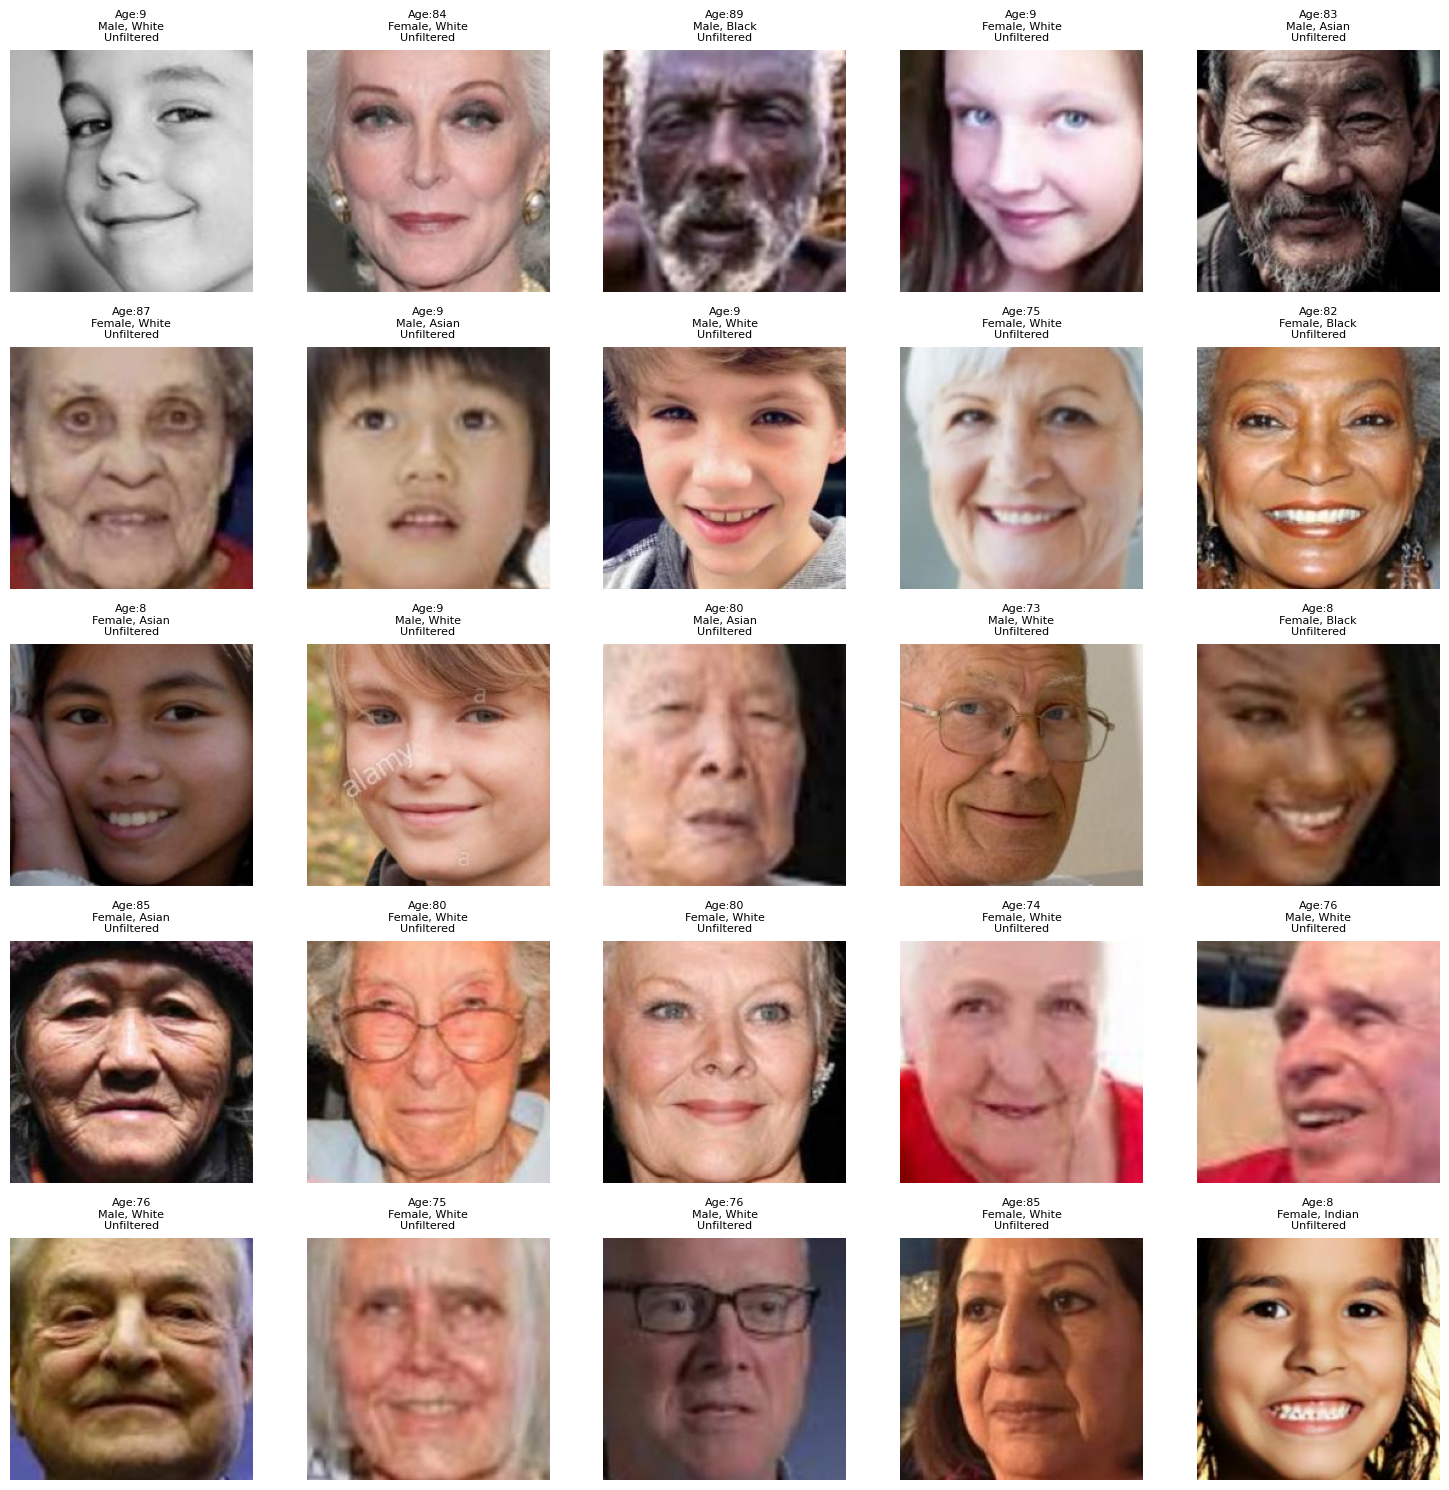

100%|██████████| 24085/24085 [02:22<00:00, 168.92it/s]


Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 911s 1s/step - age_out_loss: 15.8804 - age_out_mae: 15.8804 - ethnicity_out_accuracy: 0.4190 - ethnicity_out_loss: 1.4983 - filter_out_accuracy: 0.9892 - filter_out_loss: 0.0109 - gender_out_accuracy: 0.5310 - gender_out_loss: 0.7067 - loss: 18.0962 - val_age_out_loss: 15.8447 - val_age_out_mae: 15.8147 - val_ethnicity_out_accuracy: 0.4063 - val_ethnicity_out_loss: 1.4578 - val_filter_out_accuracy: 1.0000 - val_filter_out_loss: 4.5577e-11 - val_gender_out_accuracy: 0.6678 - val_gender_out_loss: 0.6132 - val_loss: 17.8859
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 903s 1s/step - age_out_loss: 11.9229 - age_out_mae: 11.9228 - ethnicity_out_accuracy: 0.5000 - ethnicity_out_loss: 1.2788 - filter_out_accuracy: 1.0000 - filter_out_loss: 2.3383e-09 - gender_out_accuracy: 0.7584 - gender_out_loss: 0.5163 - loss: 13.7179 - val_age_out_loss: 8.0036 - val_age_out_mae: 7.9783 - val_ethnicity_out_accuracy: 0.5194 - val_ethnicity_out_loss: 1.2475 - val_filter_out

In [ ]:
# --- Importing Modules ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.utils import to_categorical

# --- Load Dataset from UTKFace ---
BASE_DIR = "/content/drive/MyDrive/UTKFace"

image_paths, age_labels, gender_labels, ethnicity_labels, filter_labels = [], [], [], [], []

def is_filtered(filename):
    return 1 if 'filtered' in filename.lower() else 0

for filename in tqdm(os.listdir(BASE_DIR)):
    if filename.endswith(".jpg"):
        try:
            parts = filename.split('_')
            age = int(parts[0])
            gender = int(parts[1])
            ethnicity = int(parts[2])
            image_path = os.path.join(BASE_DIR, filename)
            is_filter = is_filtered(filename)

            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
            ethnicity_labels.append(ethnicity)
            filter_labels.append(is_filter)
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels,
    'ethnicity': ethnicity_labels,
    'filtered': filter_labels
})

if df.empty:
    print("❌ No data found. Check UTKFace folder path or file names.")
    exit()

# --- Data Visualization ---
img = Image.open(df.iloc[0]['image'])
plt.axis('off')
plt.imshow(img)
plt.title(f"Age: {df.iloc[0]['age']} | Gender: {df.iloc[0]['gender']} | Ethnicity: {df.iloc[0]['ethnicity']} | Filtered: {df.iloc[0]['filtered']}")
plt.show()

sns.histplot(df['age'], kde=True); plt.title("Age Distribution"); plt.show()
sns.countplot(x='gender', data=df); plt.title("Gender Count"); plt.show()
sns.countplot(x='ethnicity', data=df); plt.title("Ethnicity Count"); plt.show()
sns.countplot(x='filtered', data=df); plt.title("Filtered vs Unfiltered"); plt.show()

# --- Display 25 Sample Images ---
gender_dict = {0: "Male", 1: "Female"}
ethnicity_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}

plt.figure(figsize=(15, 15))
for index in range(25):
    row = df.iloc[index]
    img = load_img(row['image'])
    plt.subplot(5, 5, index + 1)
    plt.imshow(img)
    gender = gender_dict.get(row['gender'], 'Unknown')
    ethnicity = ethnicity_dict.get(row['ethnicity'], 'Unknown')
    filtered = "Filtered" if row['filtered'] else "Unfiltered"
    plt.title(f"Age:{row['age']}\n{gender}, {ethnicity}\n{filtered}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

# --- Preprocessing ---
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(df['image']) / 255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_ethnicity = to_categorical(np.array(df['ethnicity']), num_classes=5)
y_filtered = np.array(df['filtered'])

# --- Model Architecture ---
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Gender Head
g = Dense(256, activation='relu')(x)
g = Dropout(0.3)(g)
gender_out = Dense(1, activation='sigmoid', name='gender_out')(g)

# Age Head
a = Dense(256, activation='relu')(x)
a = Dropout(0.3)(a)
age_out = Dense(1, activation='relu', name='age_out')(a)

# Ethnicity Head
e = Dense(256, activation='relu')(x)
e = Dropout(0.3)(e)
ethnicity_out = Dense(5, activation='softmax', name='ethnicity_out')(e)

# Filtered Head
f = Dense(256, activation='relu')(x)
f = Dropout(0.3)(f)
filter_out = Dense(1, activation='sigmoid', name='filter_out')(f)

# Model Definition
model = Model(inputs=inputs, outputs=[gender_out, age_out, ethnicity_out, filter_out])
model.compile(
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'mae',
        'ethnicity_out': 'categorical_crossentropy',
        'filter_out': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics={
        'gender_out': 'accuracy',
        'age_out': 'mae',
        'ethnicity_out': 'accuracy',
        'filter_out': 'accuracy'
    }
)

# --- Train the Model ---
history = model.fit(
    X,
    {
        'gender_out': y_gender,
        'age_out': y_age,
        'ethnicity_out': y_ethnicity,
        'filter_out': y_filtered
    },
    batch_size=32,
    epochs=10,
    validation_split=0.2
)

# -------------------------------
# ✅ EXTENSION: Predict New Image
# -------------------------------
from google.colab import files
uploaded = files.upload()

def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale')
    img = img.resize((128, 128), Image.Resampling.LANCZOS)
    img_array = np.array(img).reshape(1, 128, 128, 1) / 255.0
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    gender_pred, age_pred, ethnicity_pred, filter_pred = model.predict(img_array)

    gender = "Male" if gender_pred[0][0] < 0.5 else "Female"
    age = int(age_pred[0][0])
    ethnicity = ethnicity_dict[np.argmax(ethnicity_pred[0])]
    filtered = "Filtered" if filter_pred[0][0] > 0.5 else "Unfiltered"

    print(f"\n📷 Prediction for image: {image_path}")
    print(f"👤 Gender    : {gender}")
    print(f"🎂 Age       : {age}")
    print(f"🌍 Ethnicity : {ethnicity}")
    print(f"🔍 Filtered  : {filtered}")

    # Show Image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{gender}, {age} yrs\n{ethnicity} | {filtered}")
    plt.show()

# Run prediction on uploaded image
image_path = list(uploaded.keys())[0]
predict_image(image_path)


100%|██████████| 24088/24088 [00:00<00:00, 137777.52it/s]


Skipping 61_1_20170109150557335.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Skipping 61_1_20170109142408075.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping 39_1_20170116174525125.jpg.chip.jpg due to error: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'


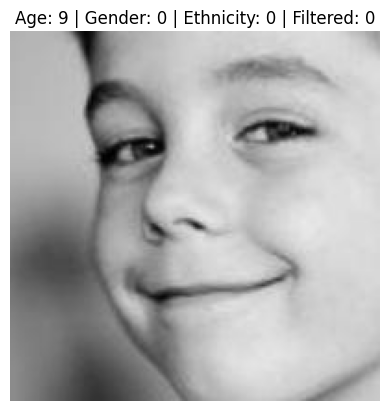

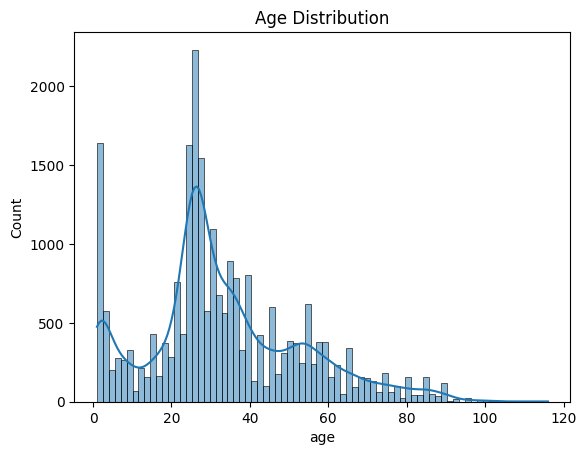

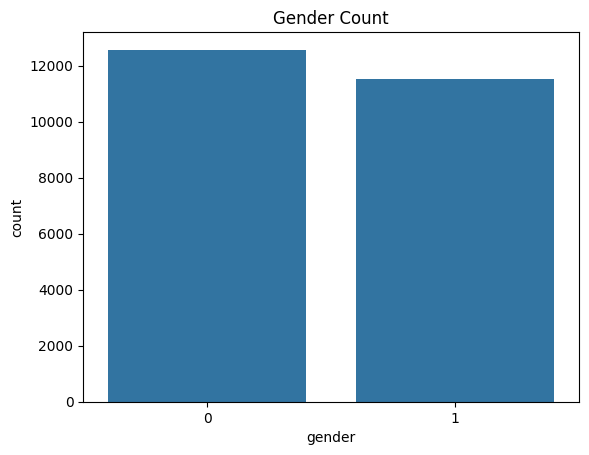

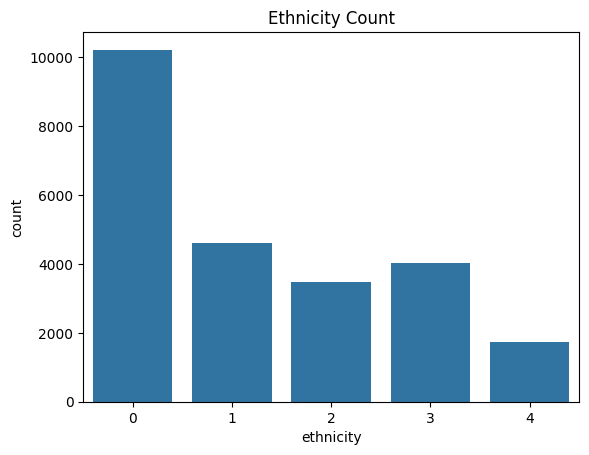

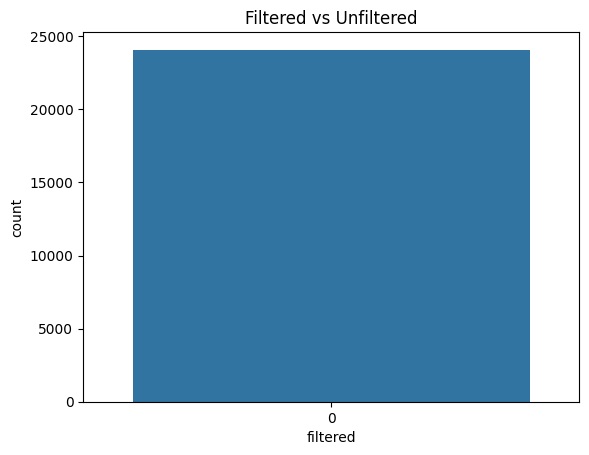

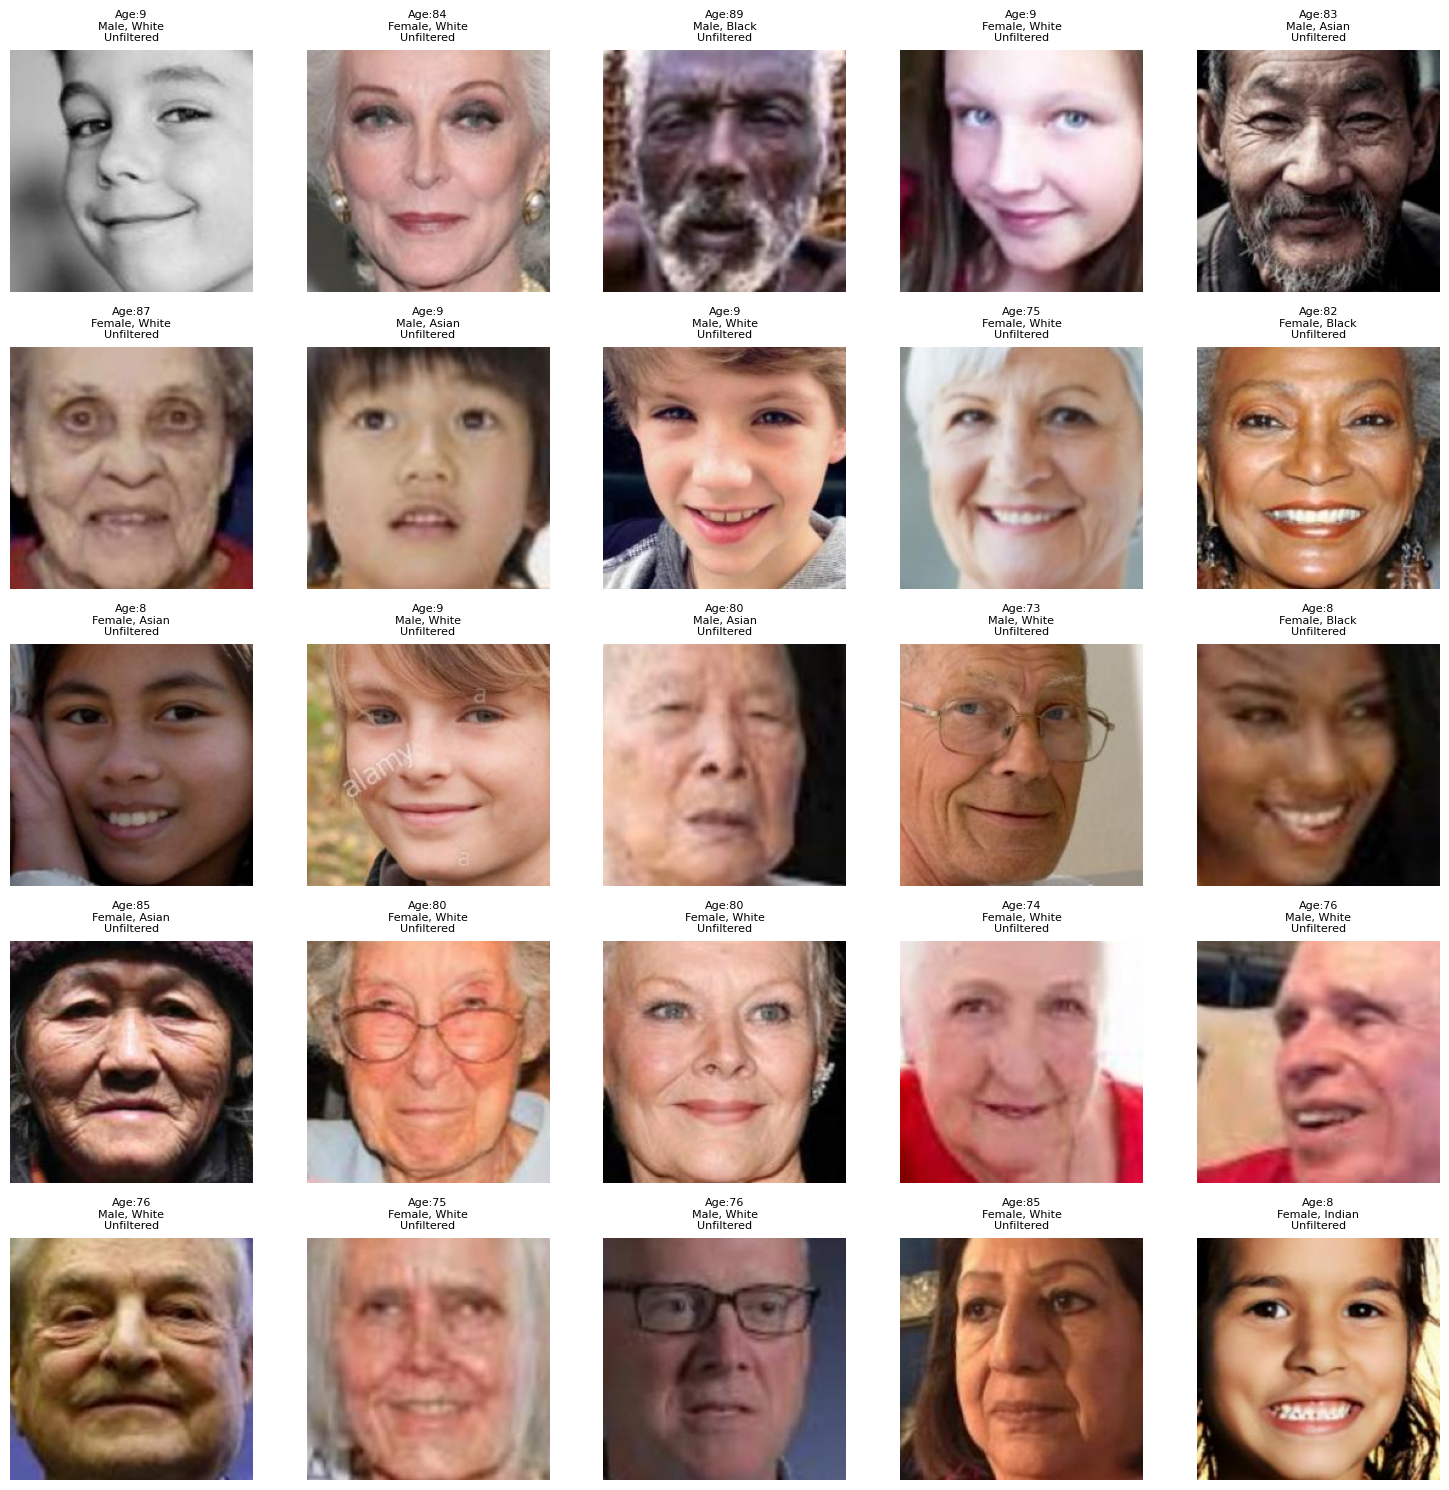

 13%|█▎        | 3172/24085 [25:13<2:27:42,  2.36it/s]

In [ ]:
# --- Importing Modules ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.utils import to_categorical

# --- Load Dataset from UTKFace ---
BASE_DIR = "/content/drive/MyDrive/UTKFace"

image_paths, age_labels, gender_labels, ethnicity_labels, filter_labels = [], [], [], [], []

def is_filtered(filename):
    return 1 if 'filtered' in filename.lower() else 0

for filename in tqdm(os.listdir(BASE_DIR)):
    if filename.endswith(".jpg"):
        try:
            parts = filename.split('_')
            age = int(parts[0])
            gender = int(parts[1])
            ethnicity = int(parts[2])
            image_path = os.path.join(BASE_DIR, filename)
            is_filter = is_filtered(filename)

            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
            ethnicity_labels.append(ethnicity)
            filter_labels.append(is_filter)
        except Exception as e:
            print(f"Skipping {filename} due to error: {e}")

df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels,
    'ethnicity': ethnicity_labels,
    'filtered': filter_labels
})

if df.empty:
    print("❌ No data found. Check UTKFace folder path or file names.")
    exit()

# --- Data Visualization ---
img = Image.open(df.iloc[0]['image'])
plt.axis('off')
plt.imshow(img)
plt.title(f"Age: {df.iloc[0]['age']} | Gender: {df.iloc[0]['gender']} | Ethnicity: {df.iloc[0]['ethnicity']} | Filtered: {df.iloc[0]['filtered']}")
plt.show()

sns.histplot(df['age'], kde=True); plt.title("Age Distribution"); plt.show()
sns.countplot(x='gender', data=df); plt.title("Gender Count"); plt.show()
sns.countplot(x='ethnicity', data=df); plt.title("Ethnicity Count"); plt.show()
sns.countplot(x='filtered', data=df); plt.title("Filtered vs Unfiltered"); plt.show()

# --- Display 25 Sample Images ---
gender_dict = {0: "Male", 1: "Female"}
ethnicity_dict = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Others"}

plt.figure(figsize=(15, 15))
for index in range(25):
    row = df.iloc[index]
    img = load_img(row['image'])
    plt.subplot(5, 5, index + 1)
    plt.imshow(img)
    gender = gender_dict.get(row['gender'], 'Unknown')
    ethnicity = ethnicity_dict.get(row['ethnicity'], 'Unknown')
    filtered = "Filtered" if row['filtered'] else "Unfiltered"
    plt.title(f"Age:{row['age']}\n{gender}, {ethnicity}\n{filtered}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()

# --- Preprocessing ---
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X = extract_features(df['image']) / 255.0
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_ethnicity = to_categorical(np.array(df['ethnicity']), num_classes=5)
y_filtered = np.array(df['filtered'])

# --- Model Architecture ---
input_shape = (128, 128, 1)
inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Gender Head
g = Dense(256, activation='relu')(x)
g = Dropout(0.3)(g)
gender_out = Dense(1, activation='sigmoid', name='gender_out')(g)

# Age Head
a = Dense(256, activation='relu')(x)
a = Dropout(0.3)(a)
age_out = Dense(1, activation='relu', name='age_out')(a)

# Ethnicity Head
e = Dense(256, activation='relu')(x)
e = Dropout(0.3)(e)
ethnicity_out = Dense(5, activation='softmax', name='ethnicity_out')(e)

# Filtered Head
f = Dense(256, activation='relu')(x)
f = Dropout(0.3)(f)
filter_out = Dense(1, activation='sigmoid', name='filter_out')(f)

# Model Definition
model = Model(inputs=inputs, outputs=[gender_out, age_out, ethnicity_out, filter_out])
model.compile(
    loss={
        'gender_out': 'binary_crossentropy',
        'age_out': 'mae',
        'ethnicity_out': 'categorical_crossentropy',
        'filter_out': 'binary_crossentropy'
    },
    optimizer='adam',
    metrics={
        'gender_out': 'accuracy',
        'age_out': 'mae',
        'ethnicity_out': 'accuracy',
        'filter_out': 'accuracy'
    }
)

# --- Train the Model ---
history = model.fit(
    X,
    {
        'gender_out': y_gender,
        'age_out': y_age,
        'ethnicity_out': y_ethnicity,
        'filter_out': y_filtered
    },
    batch_size=32,
    epochs=10,
    validation_split=0.2
)

# -------------------------------
# ✅ EXTENSION: Upload & Predict Image
# -------------------------------
from google.colab import files

def preprocess_image(image_path):
    img = load_img(image_path, color_mode='grayscale')
    img = img.resize((128, 128), Image.Resampling.LANCZOS)
    img_array = np.array(img).reshape(1, 128, 128, 1) / 255.0
    return img_array

def predict_image(image_path):
    img_array = preprocess_image(image_path)
    gender_pred, age_pred, ethnicity_pred, filter_pred = model.predict(img_array)

    gender = "Male" if gender_pred[0][0] < 0.5 else "Female"
    age = int(age_pred[0][0])
    ethnicity = ethnicity_dict[np.argmax(ethnicity_pred[0])]
    filtered = "Filtered" if filter_pred[0][0] > 0.5 else "Unfiltered"

    print(f"\n📷 Prediction for image: {image_path}")
    print(f"👤 Gender    : {gender}")
    print(f"🎂 Age       : {age}")
    print(f"🌍 Ethnicity : {ethnicity}")
    print(f"🔍 Filtered  : {filtered}")

    # Show Image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{gender}, {age} yrs\n{ethnicity} | {filtered}")
    plt.show()

# --- Upload and Predict ---
print("📤 Please upload an image (JPG/PNG)")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
predict_image(image_path)
